In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery

In [2]:
query_str = """with semrel_teacher_results as (
    SELECT
        mmxRequestUUID,
        guid,
        r.resultType,
        query,
        listingId,
        r.date,
        platform,
        userLanguage,
        userCountry,
        CASE 
            WHEN classId = 1 THEN 'Irrelevant' 
            WHEN classId = 2 THEN 'Partial'
            WHEN classId = 3 THEN 'Relevant' 
        END AS semrelClass,
        rankingRank
    FROM `etsy-data-warehouse-prod.search.sem_rel_hydrated_daily_requests` r
    JOIN `etsy-data-warehouse-prod.search.sem_rel_query_listing_metrics` USING (tableUUID)
    WHERE modelName = "v3-finetuned-llama-8b" 
    AND r.date between "2025-08-07" and "2025-08-14"
    AND pageNum = 1
    AND r.resultType = "organic"
),
agg_requests as (
    select 
        mmxRequestUUID, 
        query, 
        platform, 
        userLanguage,
        userCountry,
        count(*) as n_total, 
        sum(if(semrelClass = 'Relevant', 1, 0)) as n_em,
        array_agg(listingId) as listingIds
    from semrel_teacher_results
    group by mmxRequestUUID, query, platform, userLanguage, userCountry
),
valid_requests as (
    select * from agg_requests
    where (
        (platform = "web" and n_total = 48) or
        (platform = "mweb" and n_total = 34) or 
        (platform = "boe" and n_total = 28)
    )
)
select *, n_em / n_total as pct_em
from valid_requests
"""

client = bigquery.Client(project="etsy-search-ml-dev")
query_job = client.query(query_str)
rows = query_job.result()
df = rows.to_dataframe()

In [3]:
df.shape

(136817, 9)

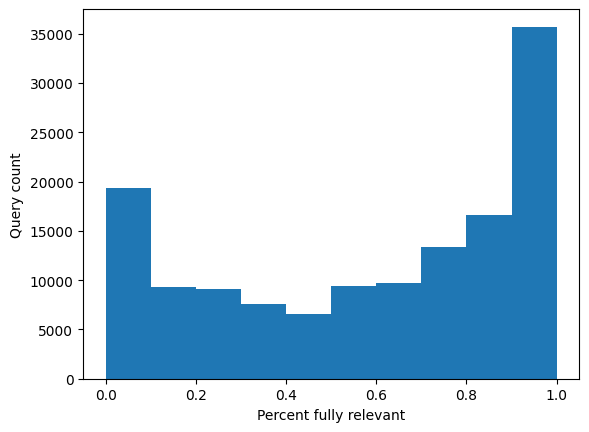

In [4]:
plt.hist(df.pct_em)
plt.xlabel("Percent fully relevant")
plt.ylabel("Query count")
plt.show()

In [6]:
web_df = df[df.platform == "web"]

In [16]:
web_df[web_df.pct_em < 0.4][["query", "listingIds", "pct_em"]].head(50)

,query,listingIds,pct_em
0,cephalotus follicularis live,"[4337192525, 1754320189, 4346454498, 434093784...",0.145833
1,new look 6449,"[1892947239, 4346786068, 1701541607, 123299744...",0.208333
3,white moss,"[4342246686, 1118321791, 4313967869, 169612812...",0.104167
5,versos del esp&iacute;ritu santo,"[1308796778, 1465393354, 1789830598, 181332047...",0.145833
8,laminated chart of histamine inducing food,"[4310395823, 4310882245, 1704345479, 176864434...",0.125000
9,medieval metal headband,"[4344933378, 637289570, 1692057189, 4335698777...",0.395833
11,auburn mom mug,"[1323841289, 700635186, 1582227326, 928876535,...",0.270833
14,الحيوانات و اطفال الحيوانات,"[4307040086, 4349243944, 1888825112, 808541055...",0.104167
15,"Val di Funes, Italy Wall Art","[1629967155, 1685532559, 4298639174, 180259240...",0.145833
16,service portfolio,"[1449410012, 4299569391, 1259216064, 113706627...",0.104167


In [17]:
web_df[web_df.pct_em > 0.8][["query", "listingIds"]].head(50)

,query,listingIds
84470,bella canvas 3010 model mockup,"[1905422275, 1777184405, 1778324481, 176411860..."
84471,fox fur coat,"[1329528280, 4343209986, 4336429727, 431355473..."
84472,machine embroidery pinwheel,"[182006758, 673446758, 1419952370, 522659012, ..."
84473,the last unicorn,"[4305605022, 1667352306, 1846280674, 433031111..."
84474,custom name couples bracelet,"[641389200, 1687050161, 951555947, 1522077370,..."
84475,breakaway cord lanyard,"[4316638668, 4327159761, 1301546981, 159704642..."
84476,bear baby shower,"[4310431731, 1677038829, 1768966395, 153240423..."
84477,turtle teacher shir,"[1786937263, 4335137438, 4337353175, 432639765..."
84478,crystal beads,"[1522801194, 1590332061, 810819519, 791981349,..."
84479,mens levi cut offs,"[4313697824, 1807212831, 1738697990, 434012926..."


In [18]:
web_df["query_length"] = web_df["query"].apply(lambda x: len(np.unique(x.split(" "))))

/var/folders/gn/nsnv1hf9035bqfv9srt9s6kh0000gp/T/ipykernel_25713/2027054553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  web_df["query_length"] = web_df["query"].apply(lambda x: len(np.unique(x.split(" "))))


In [19]:
bins = [0, 0.4, 0.8, 1.0]
labels = ['low', 'medium', 'high']
web_df['pct_em_group'] = pd.cut(web_df['pct_em'], bins=bins, labels=labels, include_lowest=True)
web_df["pct_em_group"] = web_df.pct_em_group.astype(str)

/var/folders/gn/nsnv1hf9035bqfv9srt9s6kh0000gp/T/ipykernel_25713/4100370683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  web_df['pct_em_group'] = pd.cut(web_df['pct_em'], bins=bins, labels=labels, include_lowest=True)
/var/folders/gn/nsnv1hf9035bqfv9srt9s6kh0000gp/T/ipykernel_25713/4100370683.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  web_df["pct_em_group"] = web_df.pct_em_group.astype(str)


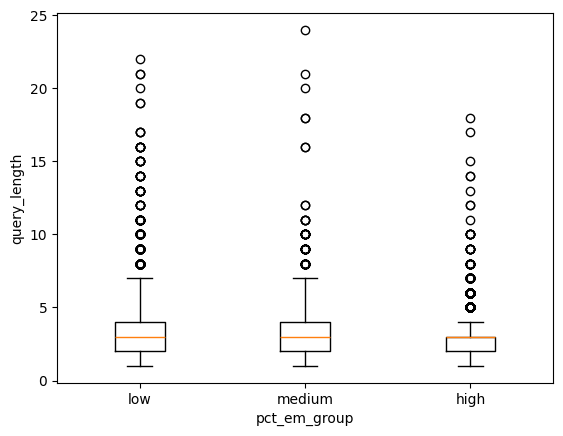

In [20]:
order = ['low', 'medium', 'high']
data = [web_df.loc[web_df['pct_em_group'] == g, 'query_length'].to_numpy() for g in order]

plt.boxplot(data, labels=order)
plt.xlabel("pct_em_group")
plt.ylabel("query_length")
plt.show()

In [22]:
print([len(d) for d in data])
print([np.sum([1 if x >= 4 else 0 for x in d]) for d in data])

[13513, 9782, 13112]
[5364, 2812, 2575]


In [23]:
web_df[web_df["query_length"] >= 8][["query", "listingIds", "pct_em"]].head(20)

,query,listingIds,pct_em
12,Custom Engraved Leather Bracelet Unisex Person...,"[1481037157, 929298259, 1593079181, 1022178111...",0.416667
135,modern wool jumbo edge cardigan womens chunky ...,"[1696736535, 1143446916, 1338290845, 139494695...",0.187500
349,pink and white website template for hair and l...,"[4335938931, 1537393595, 1848823041, 115844252...",0.104167
372,POEDAGAR Luxury Casual Watch Top Brand Fashion...,"[4348650611, 4349249269, 4348329948, 434821471...",0.104167
452,5&quot; or 10&quot; pack of quilt patterned fa...,"[1432920530, 1883208435, 4300013939, 188837442...",0.458333
584,Knitting Pattern PDF Vented Peplum Cable Jacke...,"[1823472916, 1092190670, 1164359734, 433175116...",0.312500
632,[media pointer=&quot;file-service://file-62qkW...,"[895083940, 4318325443, 1794892330, 4337973033...",0.145833
805,Miniaturas de Monstruo de Calabaza Gigante par...,"[1760636260, 1566707316, 1014775793, 188352209...",0.375000
807,license plate frame metal breast cancer awaren...,"[1562160367, 988000728, 4337598495, 1843520047...",0.375000
840,multilayer SVG/ Skate cut file/ 3D layer/ Plyw...,"[1255319133, 1149817197, 1817594201, 112912363...",0.125000


In [24]:
web_df[web_df["query_length"] >= 8][["query", "listingIds", "pct_em"]].tail(20)

,query,listingIds,pct_em
109085,Personalised something blue bridal white hanki...,"[1905376377, 741714431, 1755167966, 1300355246...",0.937500
112430,Watch Bands & Straps Slim Apple Watch Leather ...,"[1318193620, 1408171371, 1410163315, 190046031...",0.958333
112824,you say villian like its a bad thing,"[4341613622, 1744985674, 1517788035, 176138105...",0.958333
113538,set of three gallery wall art pink unique prin...,"[1872447490, 4340111166, 4329818399, 431360024...",0.958333
113569,Dried Flower Arrangements Boho Mini Dry Flower...,"[1568243068, 4327496143, 4342593258, 150666257...",0.958333
113839,i don&#39;t believe everyone was kung fu fighting,"[1618684458, 1854226106, 1501875721, 185790419...",0.958333
113880,Natural Crystal Worry Stone Smooth Polished T...,"[4324248441, 4346684599, 1760572176, 431825607...",0.958333
113989,National Day for Truth and Reconciliation / Or...,"[1764398538, 1836189311, 1878684117, 178004237...",0.958333
113990,Mockup Bella Canvas Shirt Mockup Mama and Me M...,"[1901419677, 1779316866, 1423384831, 145067870...",0.958333
122412,"Personalized Men&#39;s Leather Toiletry Bag, G...","[1703853008, 4312371674, 4344205612, 433698085...",0.979167
